# Project: Wrangle and Analyze Data

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#gather">Gather Data</a></li>
<li><a href="#assess">Assess Data</a></li>
<li><a href="#clean">Clean Data</a></li>
<li><a href="#analyze">Storing, Analyzing, and Visualizing Data</a></li>    
</ul>

<a id='intro'></a>
## Introduction

This project will gather, assess, clean, and analyze Twitter data from the tweet archive of user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog.



In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import requests
import os
import tweepy
import timeit
import json
from wordcloud import WordCloud, STOPWORDS
import seaborn as sns

<a id='gather'></a>
## Gather Data

### 1. Data provided by WeRateDogs 

In [3]:
# Read in provided archive data and display head
df_twitter_archive = pd.read_csv('twitter-archive-enhanced.csv')
df_twitter_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 2. Neural network data from Udacity server

In [4]:
# Download image predictions from Udacity server and view head
url="https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv"
response = requests.get(url)
open('image_predictions.tsv', 'wb').write(response.content)
df_image_predictions = pd.read_csv('image_predictions.tsv', sep = '\t')
df_image_predictions.head()


,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 3. Additional Twitter API data from WeRateDogs

In [11]:
# Create access variables
consumer_key = 'Private'
consumer_secret = 'Private'
access_token = 'Private'
access_secret = 'Private'

In [12]:
# Create API object
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)
api = tweepy.API(auth, wait_on_rate_limit = True, wait_on_rate_limit_notify = True)

In [13]:
# Create error counter
errors_count = 0

# Print start message for timing completion purposes
start = timeit.timeit()
print("Executing gathering operation")

# Create variable of tweet IDs to match to twitter archive dataframe 
tweet_ids = df_twitter_archive.tweet_id.values

# Gather data and write to JSON file
with open('tweet_json.txt', 'w') as output:
    for tweet_id in tweet_ids:
        try:
            tweet = api.get_status(tweet_id, tweet_mode='extended')
            json.dump(tweet._json, output)
            output.write('\n')
        except tweepy.TweepError:
            print("Error with Tweet ID:", tweet_id)            
            errors_count += 1
# Show end message to note completion of data gathering operation
end = timeit.timeit()
print("The operation took ", end - start, " seconds to complete.")
print("There were errors with ", errors_count, " tweets.")

Executing gathering operation
Error with Tweet ID: 888202515573088257
Error with Tweet ID: 873697596434513921
Error with Tweet ID: 872668790621863937
Error with Tweet ID: 872261713294495745
Error with Tweet ID: 869988702071779329
Error with Tweet ID: 866816280283807744
Error with Tweet ID: 861769973181624320
Error with Tweet ID: 856602993587888130
Error with Tweet ID: 851953902622658560
Error with Tweet ID: 845459076796616705
Error with Tweet ID: 844704788403113984
Error with Tweet ID: 842892208864923648
Error with Tweet ID: 837366284874571778
Error with Tweet ID: 837012587749474308
Error with Tweet ID: 829374341691346946
Error with Tweet ID: 827228250799742977
Error with Tweet ID: 812747805718642688
Error with Tweet ID: 802247111496568832
Error with Tweet ID: 779123168116150273
Error with Tweet ID: 775096608509886464
Error with Tweet ID: 771004394259247104
Error with Tweet ID: 770743923962707968
Error with Tweet ID: 759566828574212096
Rate limit reached. Sleeping for: 729
Error with T

In [14]:
# Create a list for the required tweet ID, retweet count, and favorite count from JSON file
tweets_data =[]

with open('tweet_json.txt') as json_file:
    for line in json_file:
    
        tweets_dictionary = {}
        tweets_json = json.loads(line)
        
        try:
            tweets_dictionary['tweet_id'] = tweets_json['extended_entities']['media'][0]['id']
        except:
            tweets_dictionary['tweet_id'] = 'na'

        tweets_dictionary['retweet_count'] = tweets_json['retweet_count']
        tweets_dictionary['favorite_count'] = tweets_json['favorite_count']
        
        tweets_data.append(tweets_dictionary)

In [15]:
# Convert JSON data to dataframe and view head
df_additional_data = pd.DataFrame(tweets_data)
df_additional_data.head()

,favorite_count,retweet_count,tweet_id
0,35508,7507,892420639486877696
1,30742,5570,892177413194625024
2,23102,3690,891815175371796480
3,38790,7683,891689552724799489
4,37075,8292,891327551943041024


<a id='assess'></a>
## Assess Data

### First I will look for any issues with the data provided by WeRateDogs

In [16]:
# Visual assessment
df_twitter_archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
9,890240255349198849,NaN,NaN,2017-07-26 15:59:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Cassie. She is a college pup. Studying...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890240255...,14,10,Cassie,doggo,None,None,None


In [17]:
# View a sample
df_twitter_archive.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
1412,698953797952008193,NaN,NaN,2016-02-14 19:35:46 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet CeCe. She wanted to take a selfie before ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/698953797...,11,10,CeCe,None,None,None,None
1555,688894073864884227,NaN,NaN,2016-01-18 01:22:00 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Hamrick. He's covered in corn flakes. ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/688894073...,7,10,Hamrick,None,None,pupper,None
115,870374049280663552,NaN,NaN,2017-06-01 20:18:38 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She really likes the planet. Wou...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/870374049...,13,10,Zoey,None,None,None,None
1510,691444869282295808,NaN,NaN,2016-01-25 02:17:57 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Bailey. She likes flowers. 12/10 https...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/691444869...,12,10,Bailey,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
1061,741303864243200000,NaN,NaN,2016-06-10 16:19:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Theodore. He just saw an adult wearing...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/741303864...,12,10,Theodore,None,None,None,None
1221,714485234495041536,NaN,NaN,2016-03-28 16:12:09 +0000,"<a href=""http://vine.co"" rel=""nofollow"">Vine -...",This is Blitz. He screams. 10/10 (vid by @yeaa...,NaN,NaN,NaN,https://vine.co/v/iDrOvVqq0A6,10,10,Blitz,None,None,None,None
2220,668484198282485761,NaN,NaN,2015-11-22 17:40:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Good teamwork between these dogs. One is on lo...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/668484198...,9,10,None,None,None,None,None
777,776088319444877312,NaN,NaN,2016-09-14 16:00:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",I can't tap the screen to make the hearts appe...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/776088319...,10,10,None,None,None,None,None
2067,671141549288370177,NaN,NaN,2015-11-30 01:39:49 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Neat pup here. Enjoys lettuce. Long af ears. S...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/671141549...,9,10,None,None,None,None,None


I noticed a tidiness issue with the last 4 columns which show dog types, might need to consolidate into one "type" column

In [18]:
# Display info to look for null data
df_twitter_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

We were told to ignore retweets, so those rows need to be dropped.  Missing some expanded URLs.

In [19]:
# Look at value counts for dog types
doggo = df_twitter_archive.doggo.value_counts()
floofer = df_twitter_archive.floofer.value_counts()
pupper = df_twitter_archive.pupper.value_counts()
puppo = df_twitter_archive.puppo.value_counts()

print(doggo)
print(floofer)
print(pupper)
print(puppo)

None     2259
doggo      97
Name: doggo, dtype: int64
None       2346
floofer      10
Name: floofer, dtype: int64
None      2099
pupper     257
Name: pupper, dtype: int64
None     2326
puppo      30
Name: puppo, dtype: int64


Looking more into the dog type values to see if those columns can be consolidated. Will check to see if any have multiple columns with types listed.

In [20]:
# Select all "pupper" rows, then look to see if any also have "doggo" listed
multi_pupper = df_twitter_archive[df_twitter_archive['pupper'] == 'pupper']
multi_pupper['doggo'].value_counts()

None     245
doggo     12
Name: doggo, dtype: int64

Since there are rows with both pupper and doggo values, the columns cannot be consolidates.  Insted I feel they should be changed to 0 for "none" and 1 for a value.

In [21]:
# Look at numerator column values
df_twitter_archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [22]:
# Look at denominator column values
df_twitter_archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

The denominator of "10" seems to be the standard, so all other rows should be dropped as they don't fall in the same scale.

In [23]:
#Check for duplicated tweet IDs
df_twitter_archive.tweet_id.duplicated().sum()             

0

There are no duplicated tweet IDs, but the retweet/replies can be considered duplicate entries since the same information (ratings, etc.) are used.

### 1. Clean WeRateDogs Archive Data
#### Quality
* Change values of dog type columns to true or false boolean types
* Drop rows where the denominator does not equal 10
* Change datatype for timestamp

#### Tidiness
* Retweets (181 rows) should not be included.  Those entries represent a duplication of data.
* Replies (78 rows) should not be included.  Those entries represent a duplication of data.

### Next I will assess the image predictions 

In [24]:
# Visual assessment
df_image_predictions

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
5,666050758794694657,https://pbs.twimg.com/media/CT5Jof1WUAEuVxN.jpg,1,Bernese_mountain_dog,0.651137,True,English_springer,0.263788,True,Greater_Swiss_Mountain_dog,0.016199,True
6,666051853826850816,https://pbs.twimg.com/media/CT5KoJ1WoAAJash.jpg,1,box_turtle,0.933012,False,mud_turtle,0.045885,False,terrapin,0.017885,False
7,666055525042405380,https://pbs.twimg.com/media/CT5N9tpXIAAifs1.jpg,1,chow,0.692517,True,Tibetan_mastiff,0.058279,True,fur_coat,0.054449,False
8,666057090499244032,https://pbs.twimg.com/media/CT5PY90WoAAQGLo.jpg,1,shopping_cart,0.962465,False,shopping_basket,0.014594,False,golden_retriever,0.007959,True
9,666058600524156928,https://pbs.twimg.com/media/CT5Qw94XAAA_2dP.jpg,1,miniature_poodle,0.201493,True,komondor,0.192305,True,soft-coated_wheaten_terrier,0.082086,True


The data looks tidy.  I will change the columns for the predictions from "p" to "prediction" so that they are more meaningful.

In [25]:
# Look at info for datatypes and null values
df_image_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


The data types look appropriate and there do not appear to be any null values.

### Cleaning Assessment for Image Prediction Data
#### Quality
* Change the column names for predictions columns to something more meaningful

### Finally I will assess the Twitter API download data

In [26]:
# Visual assessment
df_additional_data

,favorite_count,retweet_count,tweet_id
0,35508,7507,892420639486877696
1,30742,5570,892177413194625024
2,23102,3690,891815175371796480
3,38790,7683,891689552724799489
4,37075,8292,891327551943041024
5,18692,2777,891087942176911360
6,10865,1801,890971906207338496
7,59856,16805,890729118844600320
8,25705,3827,890609177319665665
9,29361,6527,890240245463175168


I noticed an "na" value for tweet_ID, may need to drop any rows that don't have numbers.

In [27]:
# View datatypes and null values
df_additional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2331 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    2331 non-null int64
retweet_count     2331 non-null int64
tweet_id          2331 non-null object
dtypes: int64(2), object(1)
memory usage: 54.7+ KB


It looks like the tweet_id will need to be changed to integer so that the columns will be able to be merged.

In [28]:
#Check for dumplicate IDs
df_additional_data.tweet_id.duplicated().sum()

330

In [29]:
df_duplicates = df_additional_data[df_additional_data['tweet_id'].duplicated()]
df_duplicates

,favorite_count,retweet_count,tweet_id
31,0,97,na
34,18875,3318,na
41,66788,18081,na
54,115,7,na
63,292,10,na
67,0,6077,na
71,27760,6313,na
72,0,1138,na
73,0,5933,na
82,21930,4205,na


In [30]:
# Veiw a duplicate with a number to see if it is duplicate information
df_additional_data[df_additional_data.tweet_id == 671896801591607296]

,favorite_count,retweet_count,tweet_id
583,0,3909,671896801591607296
1998,8040,3909,671896801591607296


In [31]:
# View one more duplicate
df_additional_data[df_additional_data.tweet_id == 679062609438445568]

,favorite_count,retweet_count,tweet_id
885,0,7764,679062609438445568
1723,16434,7764,679062609438445568


It looks like the duplicates have the same retweet count, but one favorite count is 0 for each, so will need to remove the duplicate row where the favorite count is 0.

In [32]:
# Inspect na tweet_id
df_additional_data[df_additional_data.tweet_id == 'na'].count()

favorite_count    272
retweet_count     272
tweet_id          272
dtype: int64

These 272 rows should be dropped since they cannot be merged.

### Cleaning Assessment for API Download
#### Quality
* "na' values in tweet_id
* Duplicate tweet_id where one has a value of 0 for favorite count
* tweet_id datatype does not match the other dataframes

#### Finally, after the above issues are addressed, data should be merged into a single dataframe for analysis

<a id='clean'></a>
## Clean Data

In [33]:
# Copy all tables to new clean tables
df_twitter_archive_clean = df_twitter_archive.copy()
df_image_predictions_clean = df_image_predictions.copy()
df_additional_data_clean = df_additional_data.copy()

### 1. Clean WeRateDogs Archive Data
#### Quality
* Change values of dog type columns to true or false
* Drop rows where the denominator does not equal 10
* Change datatype for timestamp

#### Tidiness
* Retweets (181 rows) should not be included.  Those entries represent a duplication of data.
* Replies (78 rows) should not be included.  Those entries represent a duplication of data.

1. Change values of dog type columns to true or false

##### Define: Use .replace function to change the value of  the four dog type columns to boolean true|false values

##### Code: 

In [34]:
# Change values in columns using .replace
df_twitter_archive_clean.doggo.replace(('doggo', 'None'), (True, False), inplace=True)
df_twitter_archive_clean.floofer.replace(('floofer', 'None'), (True, False), inplace=True)
df_twitter_archive_clean.pupper.replace(('pupper', 'None'), (True, False), inplace=True)
df_twitter_archive_clean.puppo.replace(('puppo', 'None'), (True, False), inplace=True)

##### Test: 

In [35]:
doggo = df_twitter_archive_clean.doggo.value_counts()
floofer = df_twitter_archive_clean.floofer.value_counts()
pupper = df_twitter_archive_clean.pupper.value_counts()
puppo = df_twitter_archive_clean.puppo.value_counts()

print(doggo)
print(floofer)
print(pupper)
print(puppo)

False    2259
True       97
Name: doggo, dtype: int64
False    2346
True       10
Name: floofer, dtype: int64
False    2099
True      257
Name: pupper, dtype: int64
False    2326
True       30
Name: puppo, dtype: int64


In [36]:
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null bool
floofer                       2356 non-null bool
pupper                        2356 non-null bool
puppo                         2356 non-null bool
dtypes: bool(4), float64(4), int64(3), o

2. Drop rows where the denominator does not equal 10

##### Define:  Use .drop method to remove rows where the denominator does not equal 10 for consistancy

##### Code: 

In [37]:
# Drop rows where denominator does not equal 10
df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean.rating_denominator != 10].index, inplace = True)

##### Test: 

In [38]:
# Check to see if their are any values besides 10 for the denominator
df_twitter_archive_clean.rating_denominator.value_counts()

10    2333
Name: rating_denominator, dtype: int64

3. Change datatype for timestamp 

##### Define: Convert string datatype for timestamp column to datetime using to_datetime

##### Code: 

In [39]:
# Convert timestamp column to datetime
df_twitter_archive_clean['timestamp'] = pd.to_datetime(df_twitter_archive_clean['timestamp'])

##### Test: 

In [40]:
# Check datetype for timestamp
df_twitter_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2333 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2333 non-null int64
in_reply_to_status_id         73 non-null float64
in_reply_to_user_id           73 non-null float64
timestamp                     2333 non-null datetime64[ns]
source                        2333 non-null object
text                          2333 non-null object
retweeted_status_id           180 non-null float64
retweeted_status_user_id      180 non-null float64
retweeted_status_timestamp    180 non-null object
expanded_urls                 2278 non-null object
rating_numerator              2333 non-null int64
rating_denominator            2333 non-null int64
name                          2333 non-null object
doggo                         2333 non-null bool
floofer                       2333 non-null bool
pupper                        2333 non-null bool
puppo                         2333 non-null bool
dtypes: bool(4), datetime64[ns](

In [41]:
# Look at format for timestamp column
df_twitter_archive_clean['timestamp'].head()

0   2017-08-01 16:23:56
1   2017-08-01 00:17:27
2   2017-07-31 00:18:03
3   2017-07-30 15:58:51
4   2017-07-29 16:00:24
Name: timestamp, dtype: datetime64[ns]

4. Retweets (181 rows) should not be included. Those entries represent a duplication of data.

##### Define:  Since null values are used when messages are retweeted, drop all rows where the retweeted status ID is not a null using .drop method

##### Code: 

In [42]:
# Drop rows where retweeted_status_id is not a null value
df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean.retweeted_status_id.notnull()].index, inplace = True)

##### Test: 

In [43]:
# Check to see if there are any values in retweeted status ID which are not null
df_twitter_archive_clean.retweeted_status_id.notnull().sum()

0

5. Replies (78 rows) should not be included. Those entries represent a duplication of data.

##### Define: Use the same method as above to remove all rows where the in_reply_to_status_id is null

##### Code: 

In [44]:
# Drop rows where in_reply_to_status_id is not a null value
df_twitter_archive_clean.drop(df_twitter_archive_clean[df_twitter_archive_clean.in_reply_to_status_id.notnull()].index, inplace = True)

##### Test: 

In [45]:
# Look for non-null values
df_twitter_archive_clean.in_reply_to_status_id.notnull().sum()

0

### 2. Clean Image Data

#### Quality
* Change the column names for predictions columns to something more meaningful


##### Define: Create an array mapping the old names to the new names, then use the.rename function to rename the columns using the array

##### Code: 

In [46]:
# Rename prediction columns to something more meaningful
prediction_columns = {'p1':'prediction1', 'p1_conf':'prediction1_confidence', 'p1_dog':'prediction1_dog', 
                      'p2':'prediction2', 'p2_conf':'prediction2_confidence', 'p2_dog':'prediction2_dog',
                      'p3':'prediction1', 'p3_conf':'prediction3_confidence', 'p3_dog':'prediction3_dog',}

df_image_predictions_clean.rename(columns= prediction_columns, inplace=True)

##### Test: 

In [47]:
# View column names by looking at info
df_image_predictions_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id                  2075 non-null int64
jpg_url                   2075 non-null object
img_num                   2075 non-null int64
prediction1               2075 non-null object
prediction1_confidence    2075 non-null float64
prediction1_dog           2075 non-null bool
prediction2               2075 non-null object
prediction2_confidence    2075 non-null float64
prediction2_dog           2075 non-null bool
prediction1               2075 non-null object
prediction3_confidence    2075 non-null float64
prediction3_dog           2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


### 3. Clean API Download Data

#### Quality
* "na' values in tweet_id
* Duplicate tweet_id where one has a value of 0 for favorite count
* tweet_id datatype does not match the other dataframes

1. na' values in tweet_id

##### Define: Reassign the dataframe including all rows where tweet_id does not equal 'na'

##### Code: 

In [48]:
# Redefine data frame
df_additional_data_clean = df_additional_data_clean[df_additional_data_clean.tweet_id != 'na']

##### Test: 

In [49]:
# Look for any rows with a tweet_id of 'na'
(df_additional_data_clean.tweet_id == 'na').sum()

0

2. Duplicate tweet_id where one has a value of 0 for favorite count

In [50]:
# Show number of duplicates to delete
df_additional_data_clean.tweet_id.duplicated().sum()

59

In [51]:
#Show number of entries
df_additional_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2059 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    2059 non-null int64
retweet_count     2059 non-null int64
tweet_id          2059 non-null object
dtypes: int64(2), object(1)
memory usage: 64.3+ KB


##### Define:  59 duplicates need to be deleted, and only those duplicates where the favorite_count equals 0.  First, sort the dataframe so that the largest values for favorite_count are first, then use the drop_duplicates method and keep the first instance of the tweet_id (where favorite_count values are not 0)

##### Code: 

In [52]:
#Sort data by favorite_count, then remove duplicates, keeping the first instance of tweet_id
df_additional_data_clean.sort_values(by = 'favorite_count', ascending = False)
df_additional_data_clean.drop_duplicates(subset = 'tweet_id', keep = 'first', inplace = True)

##### Test: 

In [53]:
# Verify that 59 rows were removed
df_additional_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    2000 non-null int64
retweet_count     2000 non-null int64
tweet_id          2000 non-null object
dtypes: int64(2), object(1)
memory usage: 62.5+ KB


3. tweet_id datatype does not match the other dataframes

##### Define:  Convert string datatype in tweet_id to integer using .astype function so that data can be merged with other dataframes

##### Code: 

In [54]:
# Convert string to integer
df_additional_data_clean['tweet_id'] = df_additional_data_clean['tweet_id'].astype(int)

##### Test: 

In [55]:
# Ensure datatype for tweet_id is integer
df_additional_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    2000 non-null int64
retweet_count     2000 non-null int64
tweet_id          2000 non-null int64
dtypes: int64(3)
memory usage: 62.5 KB


In [68]:
df_additional_data_clean.tweet_id.value_counts().sort_values()

684177692749639681    1
685532287132430340    1
837820156113911808    1
781251271890235393    1
808501555154432000    1
679503367408889856    1
706290925690097664    1
671528756297736192    1
686358343338844161    1
672267563901014016    1
865359385135955968    1
667517641523761152    1
692568911158489088    1
678255458960859137    1
674038229604044801    1
709158324613324805    1
778990686406402048    1
796116435260952576    1
671141542443241472    1
730427195684999168    1
675334050127544320    1
763183833575481344    1
827324936784117760    1
668221234145046534    1
793195928287055872    1
802572675407376385    1
676946858959327232    1
675820925212823552    1
675047295654756356    1
889531127467266049    1
                     ..
850019779427667968    1
674045131608236033    1
778027018185240576    1
802239319792455680    1
699036651171897344    1
782747129714532352    1
688804831675461632    1
677700000441360384    1
866450698984185856    1
686377054594441218    1
7737046731025571

### 4. Merge all dataframes into a single dataframe

In [85]:
# First merge the archive and image prediction dataframes
df_archive_image = pd.merge(df_twitter_archive_clean, df_image_predictions_clean, on = ['tweet_id'], how = 'left')
df_archive_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 28 columns):
tweet_id                      2080 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2080 non-null datetime64[ns]
source                        2080 non-null object
text                          2080 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2077 non-null object
rating_numerator              2080 non-null int64
rating_denominator            2080 non-null int64
name                          2080 non-null object
doggo                         2080 non-null bool
floofer                       2080 non-null bool
pupper                        2080 non-null bool
puppo                         2080 non-null bool
jpg_url                       1954 non-n

In [86]:
# Next merge the API dataframe into the already merged data
df_twitter_data_complete = pd.merge(df_archive_image, df_additional_data_clean, on = ['tweet_id'], how = 'left')

In [87]:
df_additional_data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 0 to 2330
Data columns (total 3 columns):
favorite_count    2000 non-null int64
retweet_count     2000 non-null int64
tweet_id          2000 non-null int64
dtypes: int64(3)
memory usage: 62.5 KB


In [88]:
# View info for merged dataframe to check that all rows combined properly
df_twitter_data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 30 columns):
tweet_id                      2080 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2080 non-null datetime64[ns]
source                        2080 non-null object
text                          2080 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2077 non-null object
rating_numerator              2080 non-null int64
rating_denominator            2080 non-null int64
name                          2080 non-null object
doggo                         2080 non-null bool
floofer                       2080 non-null bool
pupper                        2080 non-null bool
puppo                         2080 non-null bool
jpg_url                       1954 non-n

In [76]:
df_twitter_data_complete.tweet_id.duplicated().sum()    

0

<a id='analyze'></a>
## Storing, Analyzing, and Visualizing Data

### Storing Data

In [61]:
# Save the merged and clean DataFrame to a CSV file
df_twitter_data_complete.to_csv('twitter_archive_master.csv', index=False, encoding = 'utf-8')

### Analysis and Insights

#### Insight 1: What is the most common dog type?

In [62]:
# Calculate total of each type
doggo = df_twitter_data_complete.doggo.sum()
floofer = df_twitter_data_complete.floofer.sum()
pupper = df_twitter_data_complete.pupper.sum()
puppo = df_twitter_data_complete.puppo.sum()

print('Doggo', doggo)
print('Floofer', floofer)
print('Pupper', pupper)
print('Puppo', puppo)

Doggo 83
Floofer 10
Pupper 230
Puppo 24


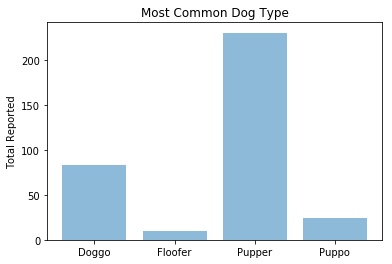

In [63]:
# Plot popularity on bar graph
dog_types = ('Doggo', 'Floofer', 'Pupper', 'Puppo')
y_pos = np.arange(len(dog_types))
totals = [doggo,floofer,pupper,puppo]

plt.bar(y_pos, totals, align='center', alpha=0.5)
plt.xticks(y_pos, dog_types)
plt.ylabel('Total Reported')
plt.title('Most Common Dog Type')

plt.show()

**"Pupper" is the most reported dog category type**

#### Insight 2: What are the most popular dog names?

In [64]:
# Create a dataframe that does not inclue "None" as a name
df_without_none = df_twitter_data_complete[df_twitter_data_complete.name != 'None']

# Isolate top 30 names by frequency
names_summary = df_without_none.groupby('name')['tweet_id'].count()
top_names = names_summary.nlargest(30)

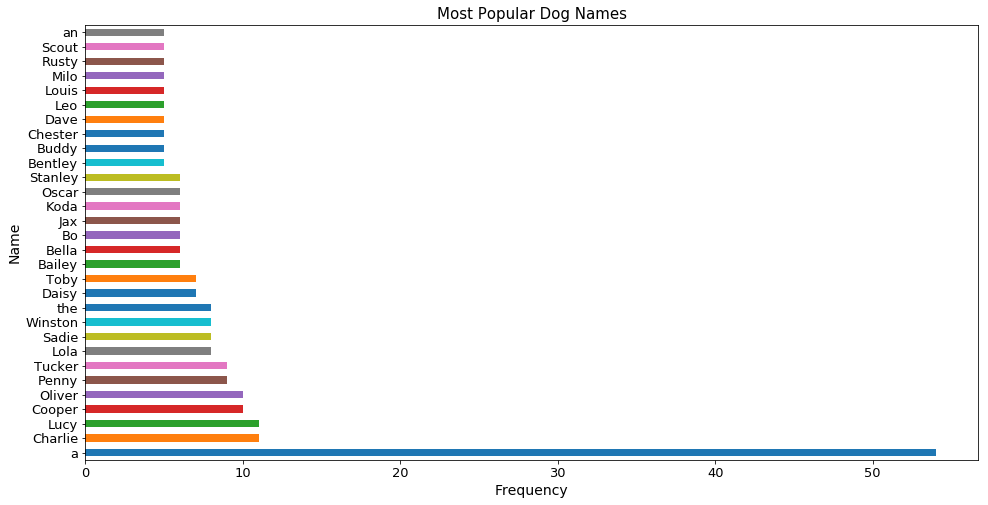

In [65]:
# Plot the most popular dog names
top_names.plot(kind='barh',figsize=(16,8),fontsize=13)
plt.title("Most Popular Dog Names",fontsize=15)
plt.xlabel('Frequency',fontsize=14)
plt.ylabel('Name',fontsize=14)
sns.set_style("whitegrid")

**The most popular name appears to be "a" which seems as erroneous as "None", therefore the actual top names include: Charlie, Lucy, Cooper, Oliver, and Penny.  I find it interesting that most are names commonly used for humans as well.**

In [66]:
df_twitter_data_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2080 entries, 0 to 2079
Data columns (total 30 columns):
tweet_id                      2080 non-null int64
in_reply_to_status_id         0 non-null float64
in_reply_to_user_id           0 non-null float64
timestamp                     2080 non-null datetime64[ns]
source                        2080 non-null object
text                          2080 non-null object
retweeted_status_id           0 non-null float64
retweeted_status_user_id      0 non-null float64
retweeted_status_timestamp    0 non-null object
expanded_urls                 2077 non-null object
rating_numerator              2080 non-null int64
rating_denominator            2080 non-null int64
name                          2080 non-null object
doggo                         2080 non-null bool
floofer                       2080 non-null bool
pupper                        2080 non-null bool
puppo                         2080 non-null bool
jpg_url                       1954 non-n

Text(0.5,1,'Retweets and favorites Scatter plot')

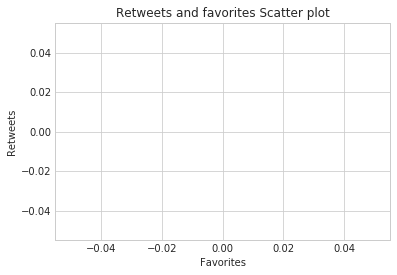

In [67]:
plt.scatter(df_twitter_data_complete['favorite_count'], df_twitter_data_complete['retweet_count'])
plt.xlabel('Favorites')
plt.ylabel('Retweets')
plt.title('Retweets and favorites Scatter plot')